# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Bertrand Lebichot - __[Bertrand.Lebichot@ulb.ac.be](mailto:Bertrand.Lebichot@ulb.ac.be)__
### Jacopo De Stefani - __[Jacopo.De.Stefani@ulb.ac.be](mailto:Jacopo.De.Stefani@ulb.ac.be)__
### Arnaud Pollaris - __[Arnaud.Pollaris@ulb.ac.be](mailto:Arnaud.Pollaris@ulb.ac.be)__

## TP 4 - Predictions: Tree-based methods

####  April 02, 2019

## Goal and dataset

The goal is to review some ML concepts :
* Classification trees
* Ensemble methods : Random forests
* Ensemble methods : Adaboost

The chosen database is about spam detection. Details can be found here :
https://archive.ics.uci.edu/ml/datasets/spambase

To import the dataset, just use package ''nutshell'' (uncomment install line if required).

Never forget that reading the documentation is useful :
*? name_of_function* or *help(name_of_function)* 

In [16]:
#install.packages("nutshell", repos = "http://cran.rstudio.com")
library("nutshell")
library("tree")
library("rpart")
data(spambase)

## Classification vs regression

Both classification and regression are sub-fields of *supervised learning*. In the two cases, we have predictive variables $X$ and a target variable $y$. The learning is said to be supervised because we use the actual value of $y$ for each samples in the training process.

In regression, $y$ is assumed to be a continuous variable. In classification however, $y$ is assumed to be a discrete variable.

The goal of a classification task is to automatically assign data to predefined discrete
classes (where $C$ is the number of classes). 

Here is a toy example :
* Knowing the two abstract features F1 and F2, and six samples for both class (the red class and the blue class), can you predict the label for the green sample ?


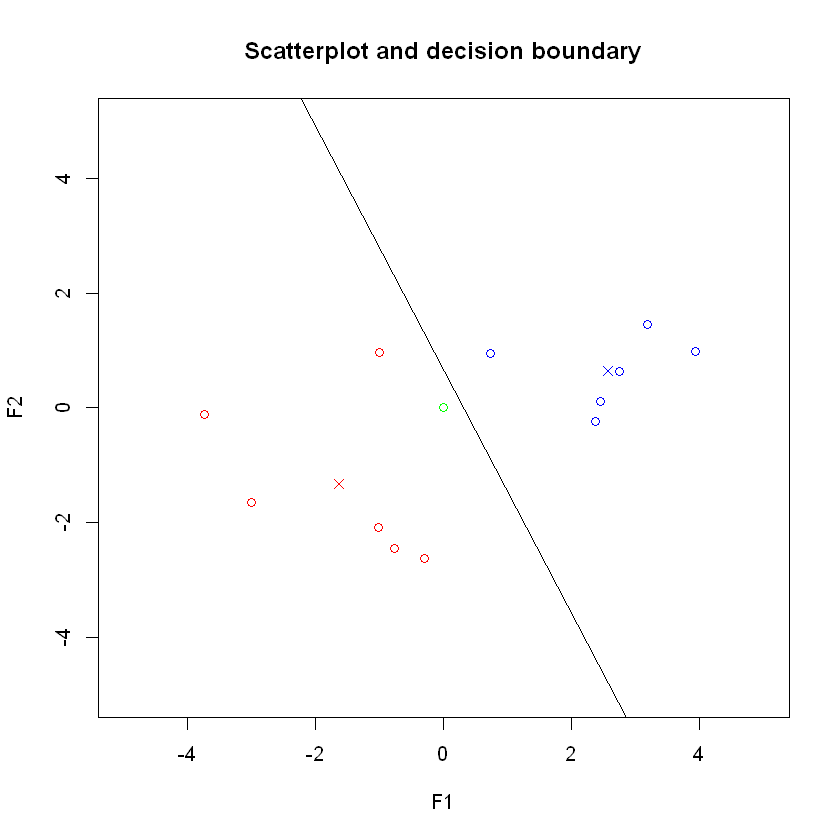

In [17]:
n = 6

# blue class data
F1 = rnorm(n, mean = +2, sd = 1)
F2 = rnorm(n, mean = +1, sd = 1)
SamplesBLUE = data.frame(F1, F2)
gBLUE = c(mean(F1),mean(F2))

# red class data
F1 = rnorm(n, mean = -2, sd = 1)
F2 = rnorm(n, mean = -1, sd = 1)
SamplesRED = data.frame(F1, F2)
gRED = c(mean(F1),mean(F2))

# draw scatterplot
plot(SamplesBLUE$F1,SamplesBLUE$F2,col="blue",main="Scatterplot and decision boundary",xlab="F1",ylab="F2",xlim=c(-5,5),ylim=c(-5,5))
points(SamplesRED$F1,SamplesRED$F2,col="red")
points(0,0,col="green")

# draw centroid of classes
points(gBLUE[1],gBLUE[2],col="blue",pch = 4)
points(gRED[1],gRED[2],col="red",pch = 4)

# draw decision boundary
midgg = c(gRED[1]+abs(gBLUE[1]-gRED[1])/2,gRED[2]+abs(gBLUE[2]-gRED[2])/2)
slope = -(gBLUE[1]-gRED[1])/(gBLUE[2]-gRED[2])
abline(a=midgg[2]-slope*midgg[1],b=slope)


### Confusion Matrix : 

In a two class setting, the confusion matrix (reporting the number of actual class / predicted class) have four entries:
 
|            | Predicted False   | Predicted True  |
|:----------:|-------------------|-----------------|
|Actual False|  True Negative TN |False Positive FP|
|Actual True | False Negative FN |True Positive TP |

## Classification trees : the basics

A decision tree (DT) partitions the input space into mutually exclusive regions (the divide-and-conquer approach). Therefore DT are easy to interpret.

DT nodes can be classified in internal nodes, determining which child node to visit next, or terminal nodes, partitioning the input space. 

In classification trees (regression trees also exist), the terminal nodes contain a label that indicates the class for the associated input region. To classify, each new sample is presented to the DT root node of the branch to one of the root’s children. The procedure is repeated recursively until a leaf. The sample is then classified as the label of that leaf.

The DT learning procedure has two steps known as *tree growing* and *tree pruning*.

* During *tree growing*, an iterative, exhaustive, search is performed to find the successive splits that best reduces a certain cost function.

    * The gini impurity (used in CART) : how often a randomly chosen element would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. It is minimum (zero) for class-homogeneous nodes.
    
    \begin{equation}
         Gini = \sum_{i=1}^C p_i * (1-p_i) = 1-\sum_{i=1}^C p_i^2\\
    \end{equation}

    * The information gain (IG, used in ID3,C4.5) : based on the concept of entropy and information content from information theory. Basically the IG is the entropy of the parent node minus the weighted sum of the children node entropy.

    \begin{equation}
         IG = -\sum_{i=1}^C p_i * log_2 (p_i) - \sum_{a} p(a) \sum_{i=1}^C Pr(i|a) * log_2 (Pr(i|a))  \\
    \end{equation}
   

* Pruning uses a complexity based measure of the tree performance to avoid overfitting.


Animated version of decision trees : http://www.r2d3.us/visual-intro-to-machine-learning-part-1/



## Dataset : spam prior, available features,...

You first have to explore the dataset before going to classification. This step can be long but is actually very important. In particular, obtain or observe the following interesting elements :
* Number of rows and columns
* Is there any missing values ?
* Spam prior
* Name and basic statistics for each variables
* Histogram (or other relevant plot) per class (spam vs non-spam)


In [18]:
dim(spambase)

[1] 4601   58

In [19]:
# No missing values -> dim(na.omit(dataset)) == dim(dataset)
dim(na.omit(spambase))

[1] 4601   58

In [20]:
# 2nd Check
apply(is.na(spambase),2,any)

word_freq_make          word_freq_address 
                     FALSE                      FALSE 
             word_freq_all               word_freq_3d 
                     FALSE                      FALSE 
             word_freq_our             word_freq_over 
                     FALSE                      FALSE 
          word_freq_remove         word_freq_internet 
                     FALSE                      FALSE 
           word_freq_order             word_freq_mail 
                     FALSE                      FALSE 
         word_freq_receive             word_freq_will 
                     FALSE                      FALSE 
          word_freq_people           word_freq_report 
                     FALSE                      FALSE 
       word_freq_addresses             word_freq_free 
                     FALSE                      FALSE 
        word_freq_business            word_freq_email 
                     FALSE                      FALSE 
             word_freq_you           word_freq_credit 
                     FALSE                      FALSE 
            word_freq_your             word_freq_font 
                     FALSE                      FALSE 
             word_freq_000            word_freq_money 
                     FALSE                      FALSE 
              word_freq_hp              word_freq_hpl 
                     FALSE                      FALSE 
          word_freq_george              word_freq_650 
                     FALSE                      FALSE 
             word_freq_lab             word_freq_labs 
                     FALSE                      FALSE 
          word_freq_telnet              word_freq_857 
                     FALSE                      FALSE 
            word_freq_data              word_freq_415 
                     FALSE                      FALSE 
              word_freq_85       word_freq_technology 
                     FALSE                      FALSE 
            word_freq_1999            word_freq_parts 
                     FALSE                      FALSE 
              word_freq_pm           word_freq_direct 
                     FALSE                      FALSE 
              word_freq_cs          word_freq_meeting 
                     FALSE                      FALSE 
        word_freq_original          word_freq_project 
                     FALSE                      FALSE 
              word_freq_re              word_freq_edu 
                     FALSE                      FALSE 
           word_freq_table       word_freq_conference 
                     FALSE                      FALSE 
       char_freq_semicolon       char_freq_left_paren 
                     FALSE                      FALSE 
    char_freq_left_bracket      char_freq_exclamation 
                     FALSE                      FALSE 
          char_freq_dollar            char_freq_pound 
                     FALSE                      FALSE 
capital_run_length_average capital_run_length_longest 
                     FALSE                      FALSE 
  capital_run_length_total                    is_spam 
                     FALSE                      FALSE


   0    1 
2788 1813 

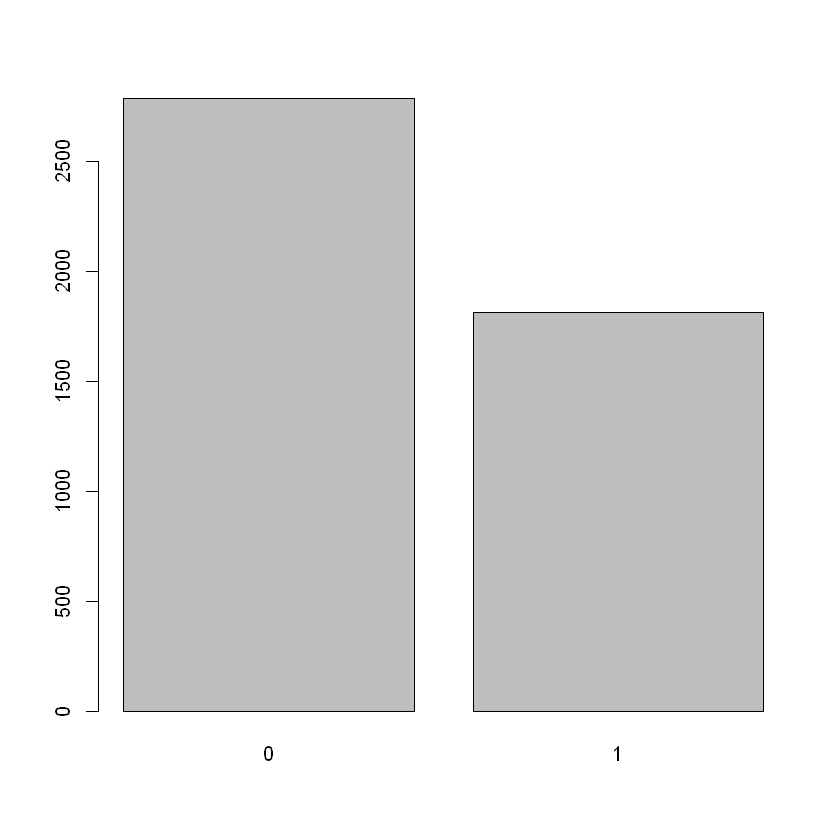

In [21]:
table(spambase$is_spam)
plot(spambase$is_spam)

In [22]:
summary(spambase)

 word_freq_make   word_freq_address word_freq_all     word_freq_3d     
 Min.   :0.0000   Min.   : 0.000    Min.   :0.0000   Min.   : 0.00000  
 1st Qu.:0.0000   1st Qu.: 0.000    1st Qu.:0.0000   1st Qu.: 0.00000  
 Median :0.0000   Median : 0.000    Median :0.0000   Median : 0.00000  
 Mean   :0.1046   Mean   : 0.213    Mean   :0.2807   Mean   : 0.06542  
 3rd Qu.:0.0000   3rd Qu.: 0.000    3rd Qu.:0.4200   3rd Qu.: 0.00000  
 Max.   :4.5400   Max.   :14.280    Max.   :5.1000   Max.   :42.81000  
 word_freq_our     word_freq_over   word_freq_remove word_freq_internet
 Min.   : 0.0000   Min.   :0.0000   Min.   :0.0000   Min.   : 0.0000   
 1st Qu.: 0.0000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 0.0000   
 Median : 0.0000   Median :0.0000   Median :0.0000   Median : 0.0000   
 Mean   : 0.3122   Mean   :0.0959   Mean   :0.1142   Mean   : 0.1053   
 3rd Qu.: 0.3800   3rd Qu.:0.0000   3rd Qu.:0.0000   3rd Qu.: 0.0000   
 Max.   :10.0000   Max.   :5.8800   Max.   :7.2700   Max.   :11.

## Classification : classifier, performance metrics, train set and test set

The goal of a classification task is to automatically assign data to predefined discrete
classes (here spam vs non-spam). The obtained model is often called a classifier. 

The most used performance metric for classification is the misclassification rate. In this notebook, we will use it but other performance metrics exist. Of course, each performance metric has its pros and cons.

The goal of supervised learning is to predict useful information. Therefore we must divide our dataset in two part :

* *train set* : From which we train our model, assuming we know the class labels
* *test set* : On which we test our model

Sometimes, when we want to validate parameters, a *validation set* is also used.

This train/test partition can be very simple (one sample in train set, one in test set, repeat) or more elaborate (10-fold cross-validation).

First, obtain the performance of a DT on the spambase dataset using a very simple partition. Also check the importance of each feature using the obtained DT. You can use packages *rpart* or *tree*.

Then plot the obtained tree using packages *rpart.plot*.

Finally, implement a 10-fold cross-validation for assessing your DT.

In [23]:
library(rpart)

spambase_idx <- sample(1:nrow(spambase))
half_split <- floor(nrow(spambase)/2)
target_variable <- ncol(spambase)

train_data <- spambase[spambase_idx[1:half_split],]
test_data <- spambase[spambase_idx[(half_split+1):nrow(spambase)],]

model <- rpart(is_spam ~ ., method="class",data=train_data)


Classification tree:
rpart(formula = is_spam ~ ., data = train_data, method = "class")

Variables actually used in tree construction:
[1] capital_run_length_total char_freq_dollar         char_freq_exclamation   
[4] word_freq_hp             word_freq_remove        

Root node error: 941/2300 = 0.40913

n= 2300 

        CP nsplit rel error  xerror     xstd
1 0.498406      0   1.00000 1.00000 0.025058
2 0.138151      1   0.50159 0.50372 0.020615
3 0.045165      2   0.36344 0.38576 0.018581
4 0.027630      4   0.27311 0.31456 0.017066
5 0.018066      5   0.24548 0.28374 0.016326
6 0.010000      6   0.22742 0.26567 0.015863
Call:
rpart(formula = is_spam ~ ., data = train_data, method = "class")
  n= 2300 

          CP nsplit rel error    xerror       xstd
1 0.49840595      0 1.0000000 1.0000000 0.02505827
2 0.13815090      1 0.5015940 0.5037194 0.02061513
3 0.04516472      2 0.3634431 0.3857598 0.01858081
4 0.02763018      4 0.2731137 0.3145590 0.01706637
5 0.01806589      5 0.2454835 

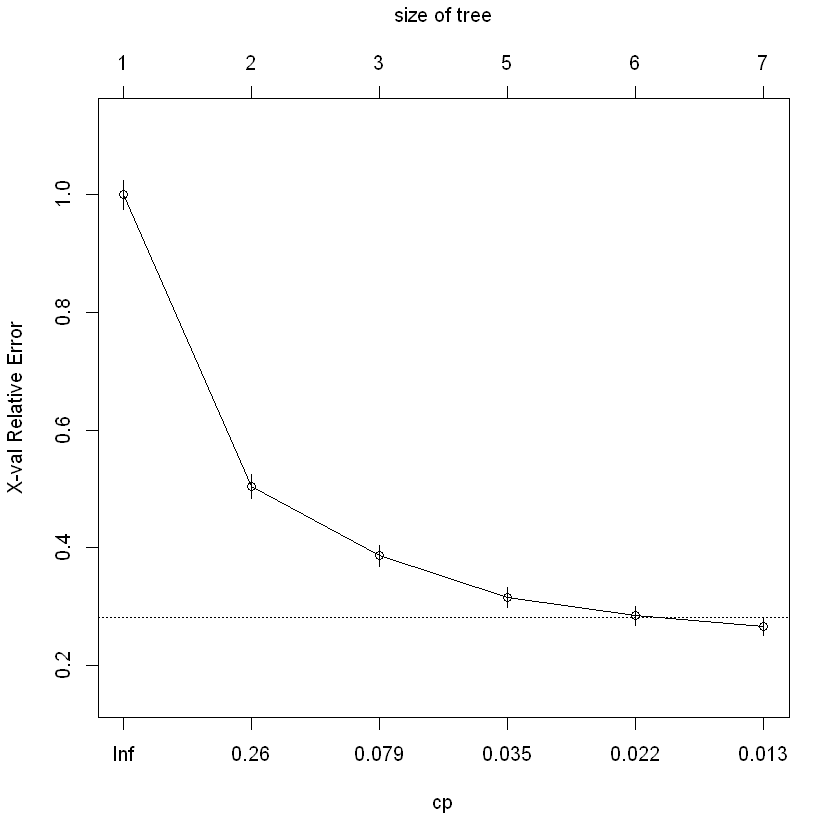

In [24]:
printcp(model) # display the results
plotcp(model) # visualize cross-validation results
summary(model) # detailed summary of splits

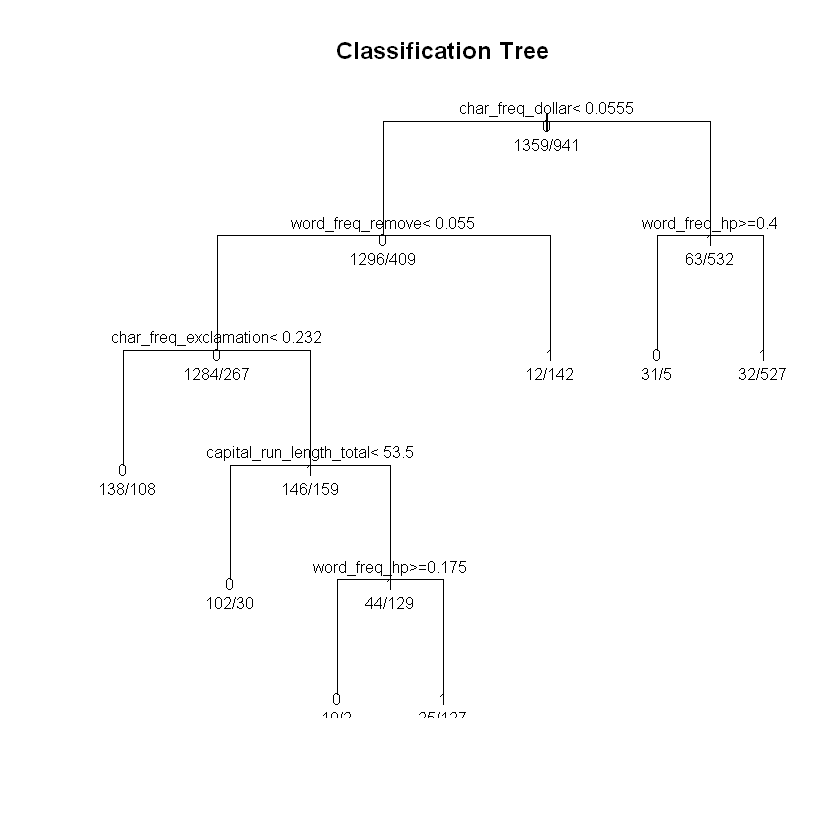

In [25]:
# plot tree
plot(model, uniform=TRUE,
   main="Classification Tree")
text(model, use.n=TRUE, all=TRUE, cex=.8)

In [26]:
model$variable.importance

char_freq_dollar           word_freq_remove 
                377.581745                 157.572582 
           word_freq_money              word_freq_000 
                129.373930                 128.270485 
  capital_run_length_total capital_run_length_longest 
                101.161570                  92.628473 
     char_freq_exclamation               word_freq_hp 
                 92.572862                  63.934531 
         word_freq_receive              word_freq_hpl 
                 62.189934                  30.732165 
capital_run_length_average             word_freq_your 
                 17.986426                  17.376717 
             word_freq_650       char_freq_left_paren 
                 15.701091                  13.413606 
             word_freq_you             word_freq_labs 
                 10.669914                   8.667057 
              word_freq_85           word_freq_telnet 
                  7.704051                   7.285233 
          word_freq_george             word_freq_free 
                  6.741045                   5.159799 
           char_freq_pound              word_freq_lab 
                  5.115993                   4.856822 
        word_freq_business         word_freq_original 
                  4.058374                   3.642616 
              word_freq_3d             word_freq_font 
                  2.046397                   2.046397 
            word_freq_will 
                  1.517588

In [27]:
Y_pred <- predict(model,test_data[,-target_variable])
Y <- test_data[,target_variable]
threshold <- 0.5

Y_hat <- Y_pred[,2] > threshold 

confusion_matrix <- table(Y_hat,(Y == 1))
confusion_matrix

       
Y_hat   FALSE TRUE
  FALSE  1345  145
  TRUE     84  727

In [28]:
# compute misclassification rate
accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
misclassification_rate = 1 - accuracy
misclassification_rate

[1] 0.09952195

### 10-fold CV

In [29]:
k = 10
target_variable <- ncol(spambase)
accuracy_vec <- array(0,k)
threshold <- 0.5

# 1. Shuffle the dataset randomly.
spambase_idx <- sample(1:nrow(spambase))

# 2. Split the dataset into k groups
max <- ceiling(nrow(spambase)/k)
splits <- split(spambase_idx, ceiling(seq_along(spambase_idx)/max))

# 3. For each unique group:
for (i in 1:k){
    #3.1 Take the group as a hold out or test data set
    train_data <- spambase[splits[[i]],]
    
    #3.2 Take the remaining groups as a training data set
    test_data <- spambase[-splits[[i]],]
    print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))
    
    #3.3 Fit a model on the training set and evaluate it on the test set
    model <- rpart(is_spam ~ ., method="class",data=train_data)
    Y_pred <- predict(model,test_data[,-target_variable])
    Y <- test_data[,target_variable]
    
    Y_hat <- Y_pred[,2] > threshold 
    confusion_matrix <- table(Y_hat,(Y == 1))
    
    #3.4 Retain the evaluation score and discard the model
    accuracy_vec[i] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
    misclassification_rate = 1 - accuracy_vec[i]
    print(paste("[INFO] - Misclassification rate -",i,"fold:",misclassification_rate))
}

#4. Summarize the skill of the model using the sample of model evaluation scores
print(paste("[INFO] - Mean misclassification rate:",1-mean(accuracy_vec[i])))



[1] "[INFO] - Training set size: 461 - Testing set size 4140"
[1] "[INFO] - Misclassification rate - 1 fold: 0.15048309178744"
[1] "[INFO] - Training set size: 461 - Testing set size 4140"
[1] "[INFO] - Misclassification rate - 2 fold: 0.13768115942029"
[1] "[INFO] - Training set size: 461 - Testing set size 4140"
[1] "[INFO] - Misclassification rate - 3 fold: 0.135265700483092"
[1] "[INFO] - Training set size: 461 - Testing set size 4140"
[1] "[INFO] - Misclassification rate - 4 fold: 0.129468599033816"
[1] "[INFO] - Training set size: 461 - Testing set size 4140"
[1] "[INFO] - Misclassification rate - 5 fold: 0.106521739130435"
[1] "[INFO] - Training set size: 461 - Testing set size 4140"
[1] "[INFO] - Misclassification rate - 6 fold: 0.14975845410628"
[1] "[INFO] - Training set size: 461 - Testing set size 4140"
[1] "[INFO] - Misclassification rate - 7 fold: 0.115217391304348"
[1] "[INFO] - Training set size: 461 - Testing set size 4140"
[1] "[INFO] - Misclassification rate - 8 fold

## Ensemble learning : random forest

A random forest (RF) consists in an ensemble of multiple decision trees trained at the same time and predicting the class as the mode of the single-tree prediction.
It combines the *bagging* idea and random selection of features, which is different for each tree. Compare to DT, RF to overfit less and reduce the variance of the estimation. Here is an implementation helper (of course, multiple variants exist) :

* The number of trees is a compromise between training time and performance.
* Each tree is built on a subset of features, usually the squared root of the total number of features, drawn randomly.
* For a new sample, the predicted class is simply the mean of predicted probabilities on all trained trees.

Implement a random forest with five trees from your (simple data partition) DT. Try with 8 and 20 features per tree. Do not use the *randomForest* package.

Then, implement a 10-fold cross-validation for assessing your DT. Plot the performances according to the number of trained trees. At that point you can use the  *randomForest* package.

In [30]:
n_trees <- 5 
features_per_tree <- 20
threshold <- 0.5

spambase_idx <- sample(1:nrow(spambase))
half_split <- floor(nrow(spambase)/2)
target_variable <- ncol(spambase)

Y_trees <- numeric()

for(i in 1:n_trees){
    selected_features <- sample(1:(ncol(spambase)-1),features_per_tree)
    #3.1 Take the group as a hold out or test data set
    train_data <- spambase[spambase_idx[1:half_split],c(selected_features,target_variable)]
    
    #3.2 Take the remaining groups as a training data set
    test_data <- spambase[spambase_idx[(half_split+1):nrow(spambase)],c(selected_features,target_variable)]
    print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))
    
    #3.3 Fit a model on the training set and evaluate it on the test set
    model <- rpart(is_spam ~ ., method="class",data=train_data)
    Y_pred <- predict(model,subset(test_data, select=-c(is_spam)))
    
    # Store the prediction of each tree
    Y_trees <- cbind(Y_trees,Y_pred[,2])
}

# Calculate the ensemble prediction
Y_hat <- apply(Y_trees,1,mean) > threshold

# Evaluate the predictions
Y <- test_data[,"is_spam"]
confusion_matrix <- table(Y_hat,(Y == 1))
confusion_matrix

accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
misclassification_rate = 1 - accuracy
misclassification_rate

[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"


       
Y_hat   FALSE TRUE
  FALSE  1291  197
  TRUE    109  704

[1] 0.1329857

[1] "[INFO] - Misclassification rate - 5 features : 0.180790960451977"
[1] "[INFO] - Misclassification rate - 10 features : 0.124293785310734"
[1] "[INFO] - Misclassification rate - 15 features : 0.142546718817905"
[1] "[INFO] - Misclassification rate - 20 features : 0.116036505867014"
[1] "[INFO] - Misclassification rate - 25 features : 0.0982181660147762"
[1] "[INFO] - Misclassification rate - 30 features : 0.0986527596697088"
[1] "[INFO] - Misclassification rate - 35 features : 0.106910039113429"
[1] "[INFO] - Misclassification rate - 40 features : 0.0943068231203824"
[1] "[INFO] - Misclassification rate - 45 features : 0.103867883528901"
[1] "[INFO] - Misclassification rate - 50 features : 0.115601912212082"
[1] "[INFO] - Misclassification rate - 55 features : 0.108213820078227"


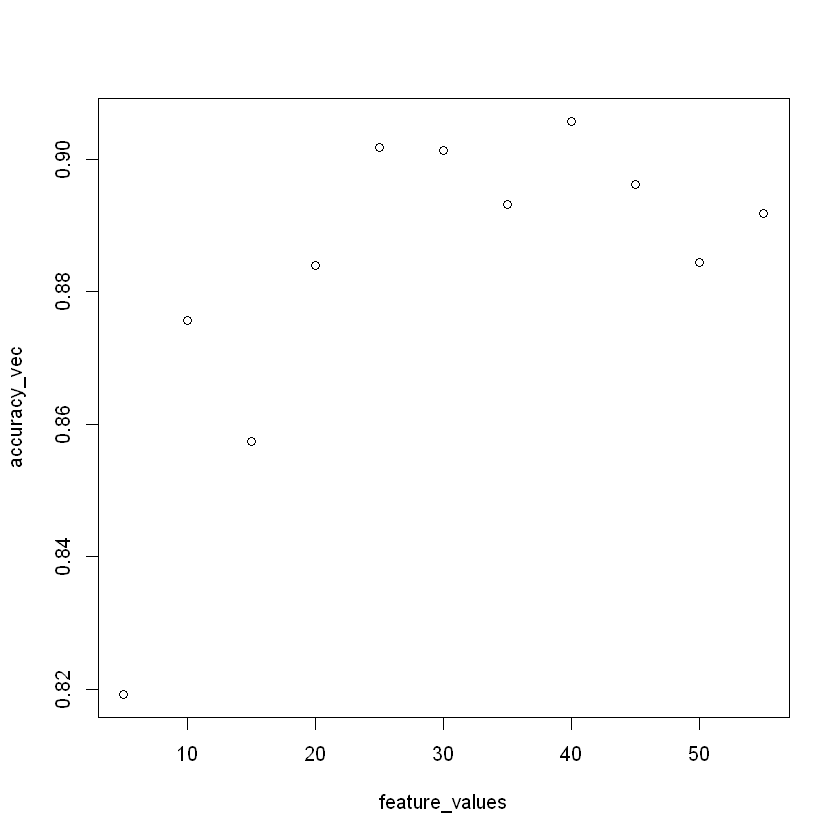

In [31]:
n_trees <- 5 
threshold <- 0.5

spambase_idx <- sample(1:nrow(spambase))
half_split <- floor(nrow(spambase)/2)
target_variable <- ncol(spambase)

feature_values <- seq(5,58,5)
accuracy_vec <- numeric()

for (features_per_tree in feature_values)
{
    Y_trees <- numeric()

    for(i in 1:n_trees){
        selected_features <- sample(1:(ncol(spambase)-1),features_per_tree)
        #3.1 Take the group as a hold out or test data set
        train_data <- spambase[spambase_idx[1:half_split],c(selected_features,target_variable)]

        #3.2 Take the remaining groups as a training data set
        test_data <- spambase[spambase_idx[(half_split+1):nrow(spambase)],c(selected_features,target_variable)]
        #print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))

        #3.3 Fit a model on the training set and evaluate it on the test set
        model <- rpart(is_spam ~ ., method="class",data=train_data)
        Y_pred <- predict(model,subset(test_data, select=-c(is_spam)))

        # Store the prediction of each tree
        Y_trees <- cbind(Y_trees,Y_pred[,2])
    }

    # Calculate the ensemble prediction
    Y_hat <- apply(Y_trees,1,mean) > threshold

    # Evaluate the predictions
    Y <- test_data[,"is_spam"]
    confusion_matrix <- table(Y_hat,(Y == 1))
    confusion_matrix

    accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
    misclassification_rate = 1 - accuracy
    accuracy_vec <- cbind(accuracy_vec,accuracy)
    print(paste("[INFO] - Misclassification rate -",features_per_tree,"features :",misclassification_rate))
}

plot(feature_values,accuracy_vec)

### 10-fold crossvalidation

In [32]:
k = 10
n_trees <- 5 
features_per_tree <- 20

target_variable <- ncol(spambase)
accuracy_vec <- array(0,k)
threshold <- 0.5

# 1. Shuffle the dataset randomly.
spambase_idx <- sample(1:nrow(spambase))

# 2. Split the dataset into k groups
max <- ceiling(nrow(spambase)/k)
splits <- split(spambase_idx, ceiling(seq_along(spambase_idx)/max))

# 3. For each unique group:
for (i in 1:k){
    
    Y_trees <- numeric()
    
    for(j in 1:n_trees){
        #3.1 Select features for the tree
        selected_features <- sample(1:(ncol(spambase)-1),features_per_tree)
        
        #3.2 Take the group as a hold out or test data set
        train_data <- spambase[splits[[i]],c(selected_features,target_variable)]

        #3.3 Take the remaining groups as a training data set
        test_data <- spambase[-splits[[i]],c(selected_features,target_variable)]
        #print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))

        #3.4 Fit a model on the training set and evaluate it on the test set
        model <- rpart(is_spam ~ ., method="class",data=train_data)
        Y_pred <- predict(model,subset(test_data, select=-c(is_spam)))

        # Store the prediction of each tree
        Y_trees <- cbind(Y_trees,Y_pred[,2])
    }
    
    
    # Calculate the ensemble prediction
    Y_hat <- apply(Y_trees,1,mean) > threshold

    # Evaluate the predictions
    Y <- test_data[,"is_spam"]
    confusion_matrix <- table(Y_hat,(Y == 1))
    confusion_matrix
    
    #3.4 Retain the evaluation score and discard the model
    accuracy_vec[i] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
    misclassification_rate = 1 - accuracy_vec[i]
    print(paste("[INFO] - Misclassification rate -",i,"fold:",misclassification_rate))
}

#4. Summarize the accuracy of the model using the sample of model evaluation scores
print(paste("[INFO] - Mean misclassification rate:",1-mean(accuracy_vec[i])))

[1] "[INFO] - Misclassification rate - 1 fold: 0.0985507246376811"
[1] "[INFO] - Misclassification rate - 2 fold: 0.130434782608696"
[1] "[INFO] - Misclassification rate - 3 fold: 0.106038647342995"
[1] "[INFO] - Misclassification rate - 4 fold: 0.116908212560387"
[1] "[INFO] - Misclassification rate - 5 fold: 0.107487922705314"
[1] "[INFO] - Misclassification rate - 6 fold: 0.102173913043478"
[1] "[INFO] - Misclassification rate - 7 fold: 0.119082125603865"
[1] "[INFO] - Misclassification rate - 8 fold: 0.106521739130435"
[1] "[INFO] - Misclassification rate - 9 fold: 0.116425120772947"
[1] "[INFO] - Misclassification rate - 10 fold: 0.0997830802603037"
[1] "[INFO] - Mean misclassification rate: 0.0997830802603037"


## Ensemble learning : Boosting

Boosting produces a serie of classifiers (here $T$ trees with $1 \leq t \leq T$). The training set used for each classifier (here tree) of the serie is chosen based on the performance of the earlier classifier(s) in the serie. Unlike bagging (like RF), the different classifier cannot be trained in parallel as they depend of the previous one(s). Here is an implementation helper (multiple variants exist) :

* The number of trees is a compromise between training time and performance. Here we will train 15 trees.
* Starting probability of picking each sample $i$ (with $1 \leq i \leq N$) is 1/N (the number of samples in train set). After the first tree, it becomes simply proportionnal to the weight $w_i$.
* The misclassification metric ($misc$) on the train set is also linearly weigthed by $w_i$.
* It allows to compute $\alpha_t = log((1-misc[t])/misc[t])$. It represents a confidence on that tree (or classifier).
* Then $\alpha_t$ allows to update $w_i = w_i*exp(alpha_t*misc_t)$.
* Finally, the predicted values are the average of all trees, linearly weigthed by $\alpha_t$.
* The trees are usually depth-forced : add *control=tree.control(Ntrain,mincut=10)* as a parameter to *tree()*.

For this exercice, we will use the *tree* package. It is therefore easier to recode the spam labels as -1/+1.

In [33]:
nsample <- nrow(spambase)
data(spambase)
spambase$is_spam = (2*as.integer(spambase$is_spam)-3) 

Now compare, in terms of misclassifcation, a regular tree against a boosted 15-trees model. You can re-use the code of the ''very simple partition'' as for the first tree we designed.

In [34]:
library(tree)

# Parameters of the algorithm
T <- 15
N <- nrow(spambase)

alpha_vec <- array(NA,T)
misclassification_vec <- array(NA,T)

# Rescaling target variable
data(spambase)
spambase$is_spam = (2*as.integer(spambase$is_spam)-3) # Data in {-1,+1}
target_variable <- ncol(spambase)


# 50/50 data split
spambase_idx <- sample(1:N)
half_split <- floor(N/2)
train_data <- spambase[spambase_idx[1:half_split],]
test_data <- spambase[spambase_idx[(half_split+1):nrow(spambase)],]


# Prediction - Single tree
tree_model <-tree(is_spam ~ ., train_data,
                  control=tree.control(half_split,mincut=10))
Y_pred_tree <- sign(predict(tree_model,test_data))

# Boosting
Y_pred_boosting <- rep(0,length(test_data))
w <- array(1/half_split,half_split)

set.seed(555)

# For each boosting iteration
for(i in 1:T){
    
    #1. Sample from the training set
    selected_samples <- sample(1:half_split,prob=w,replace=TRUE)
    
    print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))
    
    #2. Fit a model on the training set and evaluate it on the training set
    tree_model <-tree(is_spam ~ ., train_data[selected_samples,],
                  control=tree.control(half_split,mincut=10))
    Y_pred_train <- sign(predict(tree_model,train_data))
    
    #3. Compute misclassification on training set
    misclassification_vec[i] <- sum(w*as.integer(train_data$is_spam != sign(Y_pred_train)))/sum(w)
    
    #4. Computation of alpha and updating of resampling weight
    alpha_vec[i] <- log((1-misclassification_vec[i])/misclassification_vec[i])
    w <- w * exp(alpha_vec[i]*as.integer(train_data$is_spam != sign(Y_pred_train)))
    
    # Compute the predictions on the testing set and weight them by alpha
    Y_pred_boosting<-Y_pred_boosting+alpha_vec[i]*predict(tree_model,test_data)


}

# Misclassification error comparation
misclassification_error_base <- sum(as.integer(test_data$is_spam != sign(Y_pred_tree)))/length(Y_pred_tree)
misclassification_error_boosting <- sum(as.integer(test_data$is_spam != sign(Y_pred_boosting)))/length(Y_pred_boosting)

print(paste("[INFO] - Misclassification rate - Single tree:",misclassification_error_base))
print(paste("[INFO] - Misclassification rate - Boosted tree:",misclassification_error_boosting))


[1] "[INFO] - Training set size: 2300 - Testing set size 2301"


Warning message in Y_pred_boosting + alpha_vec[i] * predict(tree_model, test_data):
"longer object length is not a multiple of shorter object length"

[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Training set size: 2300 - Testing set size 2301"
[1] "[INFO] - Misclassification rate - Single tree: 0.114732724902216"
[1] "[INFO] - Misclassification rate - Boosted 